In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.mixed_linear_model import MixedLM
import pingouin as pg
# from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice

plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/reward_overrep"
os.makedirs(figdir, exist_ok = True)

In [3]:
class LMM_PeriRewardPlaceCellFrac:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'days_z': sp.stats.zscore(days), 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'm': [],
                                'ko':[],
                                'day':[], 
                                'dz': [], 
                                'lr':[], 
                                'novfam':[], 
                                'frac': [], 
                                'novfam_x_day':[],
                                'ko_x_day': [], 
                                'ko_x_novfam': [],
                                'intercept': []})
        self.fill_df()
        

    def fill_df(self):
        for m, mouse in enumerate(self.ctrl_mice):
            for day, dz in zip(self.days, self.days_z):
                self.argmax_perireward(u.load_single_day(mouse,day),m,0,day, dz)
                
        for m, mouse in enumerate(self.ko_mice):
            for day, dz in zip(self.days,self.days_z):
                self.argmax_perireward(u.load_single_day(mouse, day),m+len(self.ctrl_mice), 1,day, dz)
                
        
                
                
                

    def argmax_perireward(self, sess, m, ko, day, dz, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''

        
        trials_mat = sess.trial_matrices[ts_key]
        bin_edges = sess.trial_matrices['bin_edges']

        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_nov['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_nov['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 1
            else:
                cell_mask = sess.fam_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_fam['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_fam['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 0



            # smooth ratemap by 1 bin
            ratemap = sp.ndimage.filters.gaussian_filter1d(np.nanmean(trials_mat[trial_mask, :, :], axis=0), 1, axis=0)
            max_inds = np.argmax(ratemap[:,cell_mask], axis = 0) - rzone_front
            reward_frac = self.get_frac(max_inds)
            
            self.df = self.df.append({'mouse': sess.mouse, 
                                      'm': m,
                                     'ko': ko, 
                                     'day': day,
                                     'dz': dz, 
                                     'lr': _arm, 
                                     'novfam': nov, 
                                     'frac': reward_frac,
                                     'novfam_x_day': nov*dz,
                                     'ko_x_day': ko*dz,
                                     'ko_x_novfam': ko*nov,
                                     'intercept': 1}, ignore_index=True)
            
        

    @staticmethod
    def get_frac(data):
        '''

        :param frac:
        :return:
        '''
        x = np.arange(-30, 15)
        anova_mask = (x > -5) * (x <= -1)

        hist = np.array([np.count_nonzero(data.ravel() == _bin) for _bin in x.tolist()])
        hist = hist / hist.sum()
        return hist[anova_mask].sum() / hist[~anova_mask].sum()

    

In [4]:
lmm_frac = LMM_PeriRewardPlaceCellFrac()

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [4]:
lmm_frac.df.to_pickle("./df_rewardfrac.pkl")

NameError: name 'lmm_frac' is not defined

In [5]:
lmm_res = MixedLM(lmm_frac.df['frac'], lmm_frac.df[['ko', 'dz', 'novfam', 'lr', 'ko_x_day', 'intercept', 'novfam_x_day', 'ko_x_novfam']], lmm_frac.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: frac    
No. Observations:  192     Method:             REML    
No. Groups:        16      Scale:              0.0018  
Min. group size:   12      Log-Likelihood:     291.2879
Max. group size:   12      Converged:          Yes     
Mean group size:   12.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko           -0.059    0.019 -3.206 0.001 -0.096 -0.023
dz            0.010    0.005  2.012 0.044  0.000  0.020
novfam       -0.013    0.008 -1.596 0.111 -0.029  0.003
lr           -0.051    0.006 -8.392 0.000 -0.063 -0.039
ko_x_day     -0.006    0.006 -0.981 0.327 -0.018  0.006
intercept     0.272    0.013 21.441 0.000  0.247  0.297
novfam_x_day -0.003    0.006 -0.576 0.564 -0.015  0.008
ko_x_novfam  -0.028    0.012 -2.255 0.024 -0.052 -0.004
G

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [6]:
lmm_resf.pvalues

ko               1.343760e-03
dz               4.417022e-02
novfam           1.105550e-01
lr               4.764325e-17
ko_x_day         3.266826e-01
intercept       5.577737e-102
novfam_x_day     5.643062e-01
ko_x_novfam      2.412200e-02
Group Var        2.564863e-02
dtype: float64

In [8]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']==1], dv= 'frac', between = 'ko', within = 'day', subject = 'm')
print(res)

posthoc = pg.pairwise_ttests(data = lmm_frac.df[lmm_frac.df['novfam']==1], dv= 'frac', between = 'ko', within = 'day', subject = 'm', padjust='holm',parametric = False)
print(posthoc)

for day in range(6):
    mask = (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==1)
    t,p = sp.stats.ttest_ind(lmm_frac.df['frac'].loc[mask & (lmm_frac.df['ko']==0)], lmm_frac.df['frac'].loc[mask & (lmm_frac.df['ko']==1)])
    print(t,p)
# posthocs = pg.pairwise_ttests(dv='frac', within='day', subject='m',
#                               between='ko', data=lmm_frac.df[lmm_frac.df['novfam']==1])
# print(posthocs.round(3))

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.175087    1   14  0.175087  7.307815  0.017146  0.342964   
1          day  0.005810    5   70  0.001162  0.662669  0.652945  0.045194   
2  Interaction  0.010030    5   70  0.002006  1.144111  0.345510  0.075548   

        eps  
0       NaN  
1  0.740054  
2       NaN  
    Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0        day    -  0.0  1.0   True       False    NaN   67.0   two-sided   
1        day    -  0.0  2.0   True       False    NaN   60.0   two-sided   
2        day    -  0.0  3.0   True       False    NaN   60.0   two-sided   
3        day    -  0.0  4.0   True       False    NaN   68.0   two-sided   
4        day    -  0.0  5.0   True       False    NaN   54.0   two-sided   
5        day    -  1.0  2.0   True       False    NaN   37.0   two-sided   
6        day    -  1.0  3.0   True       False    NaN   59.0   two-sided   
7        day    -  1.0 

In [10]:
res = pg.mixed_anova(data = lmm_frac.df[lmm_frac.df['novfam']==0], dv= 'frac', between = 'ko', within = 'day', subject = 'm')
print(res)

posthoc = pg.pairwise_ttests(data = lmm_frac.df[lmm_frac.df['novfam']==0], dv= 'frac', between = 'ko', within = 'day', subject = 'm', padjust='holm',parametric = False)
print(posthoc)

for day in range(6):
    mask = (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==0)
    t,p = sp.stats.ttest_ind(lmm_frac.df['frac'].loc[mask & (lmm_frac.df['ko']==0)], lmm_frac.df['frac'].loc[mask & (lmm_frac.df['ko']==1)])
    print(t,p)

        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0           ko  0.085454    1   14  0.085454  12.857125  0.002982  0.478723   
1          day  0.008399    5   70  0.001680   2.161806  0.068127  0.133760   
2  Interaction  0.005133    5   70  0.001027   1.321236  0.265212  0.086236   

        eps  
0       NaN  
1  0.597147  
2       NaN  
    Contrast  day    A    B Paired  Parametric  U-val  W-val alternative  \
0        day    -  0.0  1.0   True       False    NaN   40.0   two-sided   
1        day    -  0.0  2.0   True       False    NaN   24.0   two-sided   
2        day    -  0.0  3.0   True       False    NaN   23.0   two-sided   
3        day    -  0.0  4.0   True       False    NaN   27.0   two-sided   
4        day    -  0.0  5.0   True       False    NaN   37.0   two-sided   
5        day    -  1.0  2.0   True       False    NaN   56.0   two-sided   
6        day    -  1.0  3.0   True       False    NaN   47.0   two-sided   
7        day    -  

In [10]:
lmm_resf.params['lr']

-0.05130719657759221

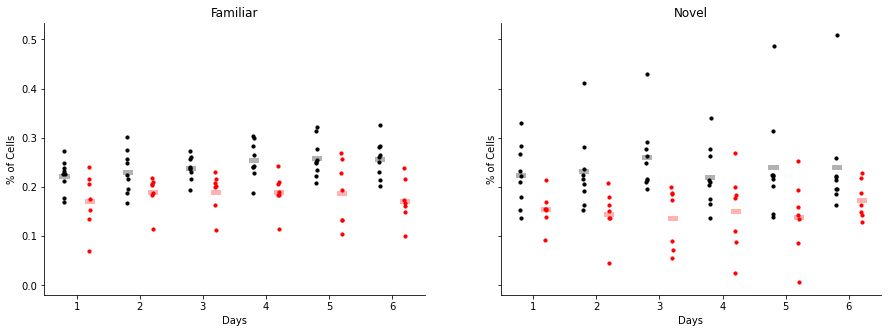

In [19]:
fig, ax = plt.subplots(1,2,figsize = [15,5], sharey=True)
s = 10
lw = 5
for day in range(6):
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==0)
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[0].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s)
    ax[0].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==1)
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax[1].scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), frac, color = 'black', s=s, alpha = 1)
    ax[1].plot(5*day  -1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==0)
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[0].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s)
    ax[0].plot(5*day  +1 + np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth =lw, alpha = .3)
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) & (lmm_frac.df['novfam']==1)
    frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax[1].scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), frac, color = 'red', s=s, alpha = 1)
    ax[1].plot(5*day +1+ np.array([-0.2,0.2]), frac.mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3)
    
    ax[0].set_title('Familiar')
    ax[1].set_title('Novel')

for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
    ax[a].set_xlabel('Days')
    ax[a].set_ylabel("% of Cells")
    ax[a].set_xticks(5*np.arange(6))
    ax[a].set_xticklabels(np.arange(1,7))
fig.savefig(os.path.join(figdir, "reward_pc_frac_summary.pdf"))

3.228462356552275 0.0012445763775868247


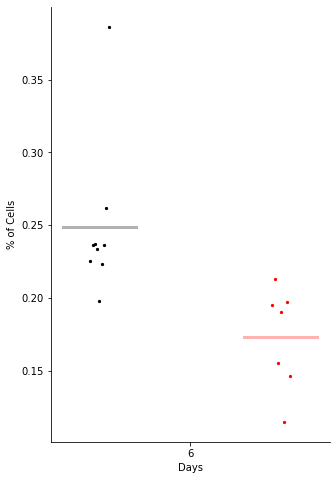

In [22]:
fig, ax = plt.subplots(figsize=[5,8])

for day in range(5,6):
    mask = (lmm_frac.df['ko']==0) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ctrl_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ctrl_mice])
    ax.scatter(5*day-.5 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_frac, color = 'black', s=5)
    ax.plot(5*day  -.5 + np.array([-0.2,0.2]), ctrl_frac.mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    
    mask = (lmm_frac.df['ko']==1) & (lmm_frac.df['day']==day) #& (lmm_frac.df['novfam']==0)
    ko_frac = np.array([lmm_frac.df['frac'].loc[mask & (lmm_frac.df['mouse']==mouse)]._values.mean() for mouse in ko_mice])
    ax.scatter(5*day+.5 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_frac, color = 'red', s=5)
    ax.plot(5*day  +.5 + np.array([-0.2,0.2]), ko_frac.mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(5,6))
ax.set_xticklabels(np.arange(6,7))
    
t,p = sp.stats.ranksums(ctrl_frac,ko_frac)
print(t,p)
fig.savefig(os.path.join(figdir, "reward_pc_frac_summary_short.pdf"))

In [9]:
class LMM_PeriRewardActivity:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'days_z': sp.stats.zscore(days), 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[],
                                'dz': [], 
                                'lr':[], 
                                'lr_x_day': [],
                                'novfam':[], 
                                'frac': [], 
                                'ko_x_day': [],
                                'novfam_x_day':[],
                                'ko_x_novfam': [],
                                'speed':[],
                                'intercept': []})
        self.fill_df()
#         self.df['speed'].apply(sp.stats.zscore)
        

    def fill_df(self):
        for mouse in self.ko_mice:
            for day, dz in zip(self.days,self.days_z):
                self.argmax_perireward(u.load_single_day(mouse, day), 1, day, dz)
                
        for mouse in self.ctrl_mice:
            for day, dz in zip(self.days, self.days_z):
                self.argmax_perireward(u.load_single_day(mouse,day),0,day, dz)
                
                
                

    def argmax_perireward(self, sess, ko,day, dz, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''

        
        trials_mat = sess.trial_matrices[ts_key]
        bin_edges = sess.trial_matrices['bin_edges']

        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_nov['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_nov['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 1
            else:
                cell_mask = sess.fam_place_cell_mask()
                rzone_front = np.argwhere((sess.rzone_fam['tfront'] <= bin_edges[1:]) * \
                                          (sess.rzone_fam['tfront'] >= bin_edges[:-1]))[0][0]
                nov = 0



            # smooth ratemap by 1 bin
            ratemap = sp.stats.zscore(np.nanmean(trials_mat[trial_mask, :, :], axis=0),axis=0)
            speedmap = np.nanmean(sess.trial_matrices['speed'][trial_mask, :], axis=0)
#             print(rzone_front,ratemap.shape)
            
#             reward_frac = self.get_frac(max_inds)
            
            self.df = self.df.append({'mouse': sess.mouse, 
                                    'ko': ko, 
                                    'day': day,
                                    'dz': dz, 
                                    'lr': _arm, 
                                    'lr_x_day': _arm*dz,
                                    'novfam': nov, 
                                    'frac': ratemap[rzone_front-5:rzone_front,:].mean(axis=0).mean(),
                                    'speed': speedmap[rzone_front-5:rzone_front].mean(),
                                    'ko_x_day': ko*dz,
                                    'novfam_x_day': nov*dz,
                                    'ko_x_novfam': ko*nov,
                                    'intercept': 1}, ignore_index=True)
            
        


In [10]:
lmm_act = LMM_PeriRewardActivity()

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [15]:
# lmm_act.df['speed']= sp.stats.zscore(lmm_act.df['speed']._values)
lmm_res = MixedLM(lmm_act.df['frac'], lmm_act.df[['ko', 
                                                  'dz', 
                                                  'novfam', 
                                                  'lr', 
                                                  #'speed', 
                                                  'ko_x_day', 
                                                  'intercept', 
                                                  'novfam_x_day', 
                                                  'ko_x_novfam',
                                                 # 'lr_x_day',
                                                 ]], lmm_act.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: frac    
No. Observations:  120     Method:             REML    
No. Groups:        10      Scale:              0.0032  
Min. group size:   12      Log-Likelihood:     137.9070
Max. group size:   12      Converged:          Yes     
Mean group size:   12.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko           -0.095    0.037 -2.576 0.010 -0.167 -0.023
dz           -0.002    0.009 -0.277 0.782 -0.020  0.015
novfam       -0.028    0.015 -1.872 0.061 -0.057  0.001
lr           -0.016    0.011 -1.495 0.135 -0.037  0.005
ko_x_day      0.002    0.010  0.204 0.838 -0.018  0.023
intercept     0.023    0.027  0.862 0.389 -0.029  0.076
novfam_x_day -0.003    0.010 -0.309 0.758 -0.024  0.017
ko_x_novfam   0.009    0.021  0.439 0.661 -0.032  0.050
G

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
lmm_resf.pvalues

ko              0.009984
dz              0.781562
novfam          0.061149
lr              0.135040
ko_x_day        0.838411
intercept       0.388839
novfam_x_day    0.757605
ko_x_novfam     0.660850
Group Var       0.078293
dtype: float64

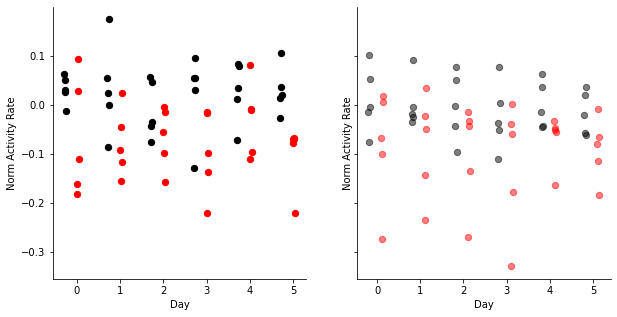

In [14]:
fig, ax = plt.subplots(1, 2, figsize = [10, 5], sharey = True)


for m, mouse in enumerate(ctrl_mice):
    mask = (lmm_act.df['ko']==0) & (lmm_act.df['mouse'] == mouse)
    
    _mask = mask & (lmm_act.df['novfam']==0)
#     print(lmm_frac.df['lr'].loc[_mask].iloc[0])
    std = lmm_act.df['frac'].loc[_mask] - lmm_resf.params['lr']*lmm_act.df['lr'].loc[_mask].iloc[0]
    x = lmm_act.df['day'].loc[mask & (lmm_act.df['novfam']==0)]
    ax[0].scatter(10*x+.1*m,std, color='black', s=40)
    
    _mask = mask & (lmm_frac.df['novfam']==1)
    std = lmm_act.df['frac'].loc[_mask] - lmm_resf.params['lr']*lmm_act.df['lr'].loc[_mask].iloc[0]
#     std = lmm_frac.df['frac'].loc[mask & (lmm_frac.df['novfam']==1)]
    x = lmm_act.df['day'].loc[mask & (lmm_act.df['novfam']==1)]
    ax[1].scatter(10*x +.1*m + 1,std, color='black', alpha = .5, s=40)
    
for m, mouse in enumerate(ko_mice):
    mask = (lmm_act.df['ko']==1) & (lmm_act.df['mouse'] == mouse)
    _mask = mask & (lmm_frac.df['novfam']==0)
    
#     std = lmm_frac.df['frac'].loc[mask & (lmm_frac.df['novfam']==0)]
    std = lmm_act.df['frac'].loc[_mask] - lmm_resf.params['lr']*lmm_act.df['lr'].loc[_mask].iloc[0]
    x = lmm_act.df['day'].loc[mask & (lmm_act.df['novfam']==0)]
    ax[0].scatter(10*x+.1*m + 3,std, color='red', s=40)
    
    _mask = mask & (lmm_act.df['novfam']==1)
    std = lmm_act.df['frac'].loc[_mask ] - lmm_resf.params['lr']*lmm_act.df['lr'].loc[_mask].iloc[0]
#     std = lmm_frac.df['frac'].loc[mask & (lmm_frac.df['novfam']==1)]
    x = lmm_act.df['day'].loc[mask & (lmm_act.df['novfam']==1)]
    ax[1].scatter(10*x +.1*m + 4,std, color='red', alpha = .5, s=40)

for i in range(2):
    ax[i].set_xticks(10.*np.arange(6) + 3)
    ax[i].set_xticklabels(np.arange(6))
    ax[i].set_xlabel('Day')

    ax[i].set_ylabel('Norm Activity Rate')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "rzone_act_summary.pdf"))




In [6]:
fam_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=True, days = np.arange(6))

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [11]:
anova_results = fam_pc_fracs.mixed_anova()

ValueError: Subject IDs cannot overlap between groups: each group in `ko_ctrl` must have a unique set of subject IDs, e.g. group1 = [1, 2, 3, ..., 10] and group2 = [11, 12, 13, ..., 20]

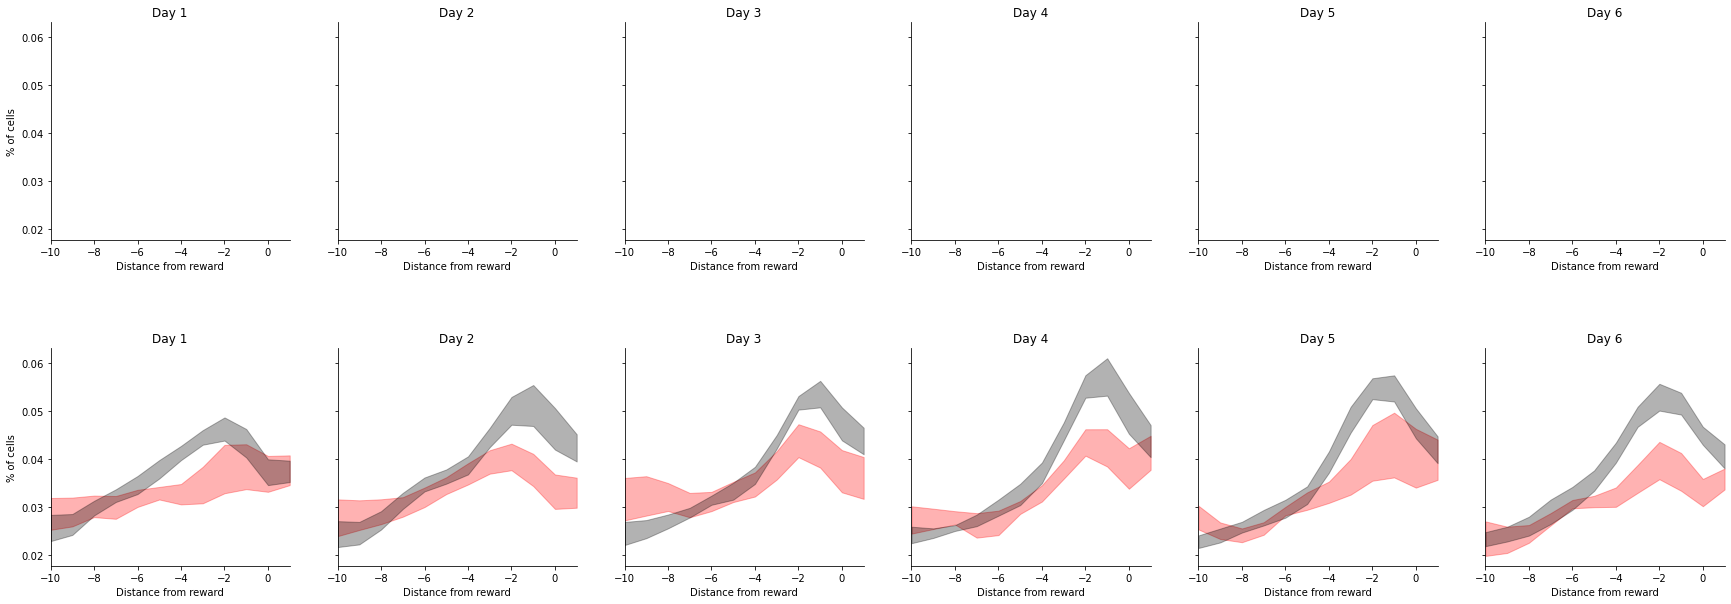

In [12]:
fig,ax = fam_pc_fracs.perireward_hist()
fig.savefig(os.path.join(figdir,'fam_placecell_frac_perireward.pdf'),format='pdf')

In [8]:
nov_pc_fracs = stx.reward_overrep.PeriRewardPlaceCellFrac(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

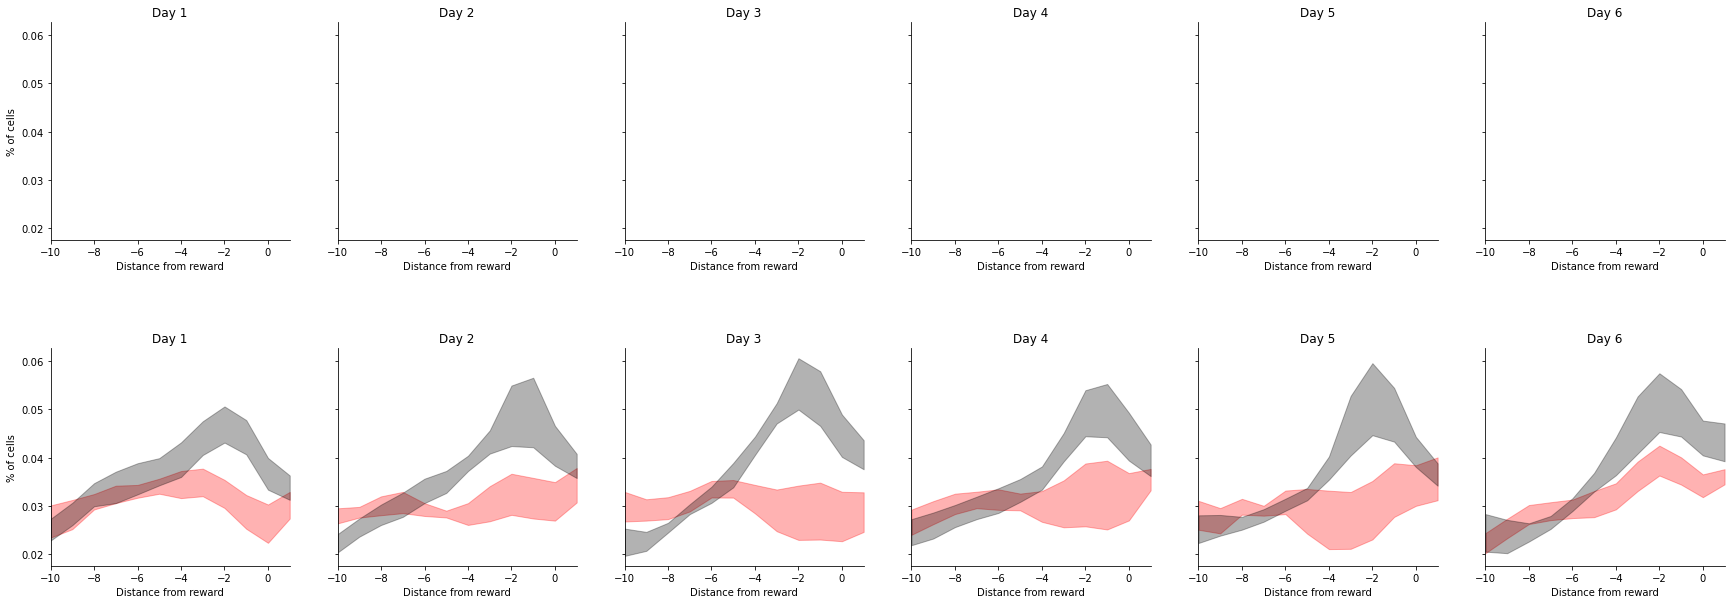

In [13]:
fig,ax = nov_pc_fracs.perireward_hist()
fig.savefig(os.path.join(figdir,"nov_placecell_frac_perireward.pdf"),format = 'pdf')


In [12]:
fam_pc_rates = stx.reward_overrep.PeriRewardPlaceCellActivity(fam=True)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

In [13]:
fam_pc_rates.mixed_anova()

TypeError: 'NoneType' object is not subscriptable

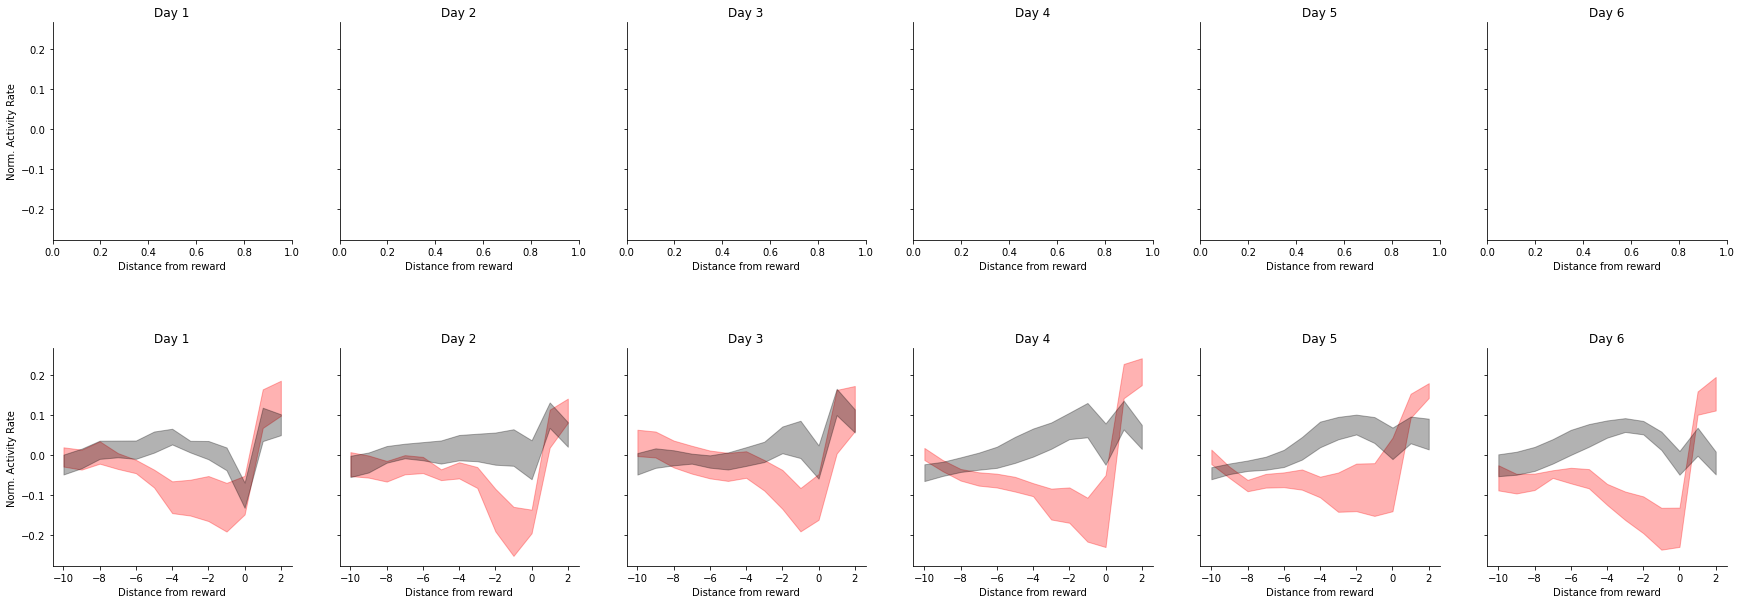

In [14]:
fig, ax = fam_pc_rates.perireward_activity()
fig.savefig(os.path.join(figdir, 'fam_perireward_act.pdf'),format = 'pdf')

In [15]:
anova_results = fam_pc_rates.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  0.509867    1   14  0.509867  16.550975  0.001151  0.541749   
1          day  0.015124    5   70  0.003025   0.793563  0.557929  0.053642   
2  Interaction  0.030726    5   70  0.006145   1.612237  0.168165  0.103268   

        eps  
0       NaN  
1  0.692731  
2       NaN  
         Contrast day  A  B Paired  Parametric         T        dof  \
0             day   -  0  1   True        True -0.179235  15.000000   
1             day   -  0  2   True        True -0.903773  15.000000   
2             day   -  0  3   True        True -0.803990  15.000000   
3             day   -  0  4   True        True -1.387804  15.000000   
4             day   -  0  5   True        True -0.598917  15.000000   
5             day   -  1  2   True        True -0.816989  15.000000   
6             day   -  1  3   True        True -0.835481  15.000000   
7             day   -  1  4   Tr

NameError: name 'pairwise_tukey' is not defined

In [16]:
nov_pc_rates = stx.reward_overrep.PeriRewardPlaceCellActivity(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

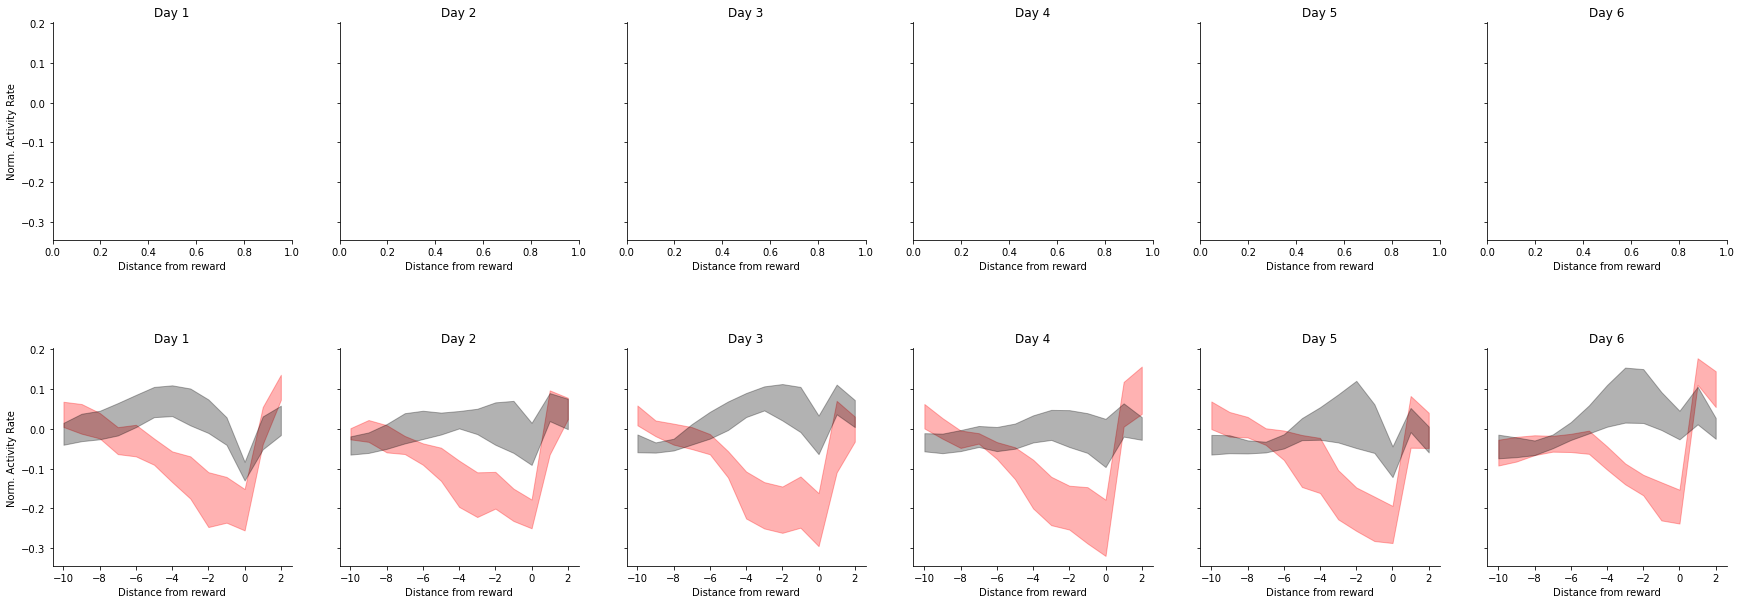

In [17]:
fig, ax = nov_pc_rates.perireward_activity()
fig.savefig(os.path.join(figdir, 'nov_perireward_act.pdf'),format = 'pdf')
# anova_results = nov_pc_rates.mixed_anova() 

In [30]:
anova_results = nov_pc_rates.mixed_anova()

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  0.909818    1   14  0.909818  12.274023  0.003511  0.467154   
1          day  0.038173    5   70  0.007635   0.948867  0.455195  0.063474   
2  Interaction  0.014170    5   70  0.002834   0.352237  0.879152  0.024542   

        eps  
0       NaN  
1  0.672036  
2       NaN  
         Contrast day  A  B Paired  Parametric         T        dof  \
0             day   -  0  1   True        True  0.749654  15.000000   
1             day   -  0  2   True        True  0.134887  15.000000   
2             day   -  0  3   True        True  1.151726  15.000000   
3             day   -  0  4   True        True  0.578222  15.000000   
4             day   -  0  5   True        True -0.534751  15.000000   
5             day   -  1  2   True        True -0.621022  15.000000   
6             day   -  1  3   True        True  0.760982  15.000000   
7             day   -  1  4   Tr

In [19]:
def get_smooth_hist(max1, max2,bins = np.arange(0,30)):
    hist, xedges, yedges = np.histogram2d(max1,max2, bins = [bins, bins], density = True)
    hist_sm = sp.ndimage.filters.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm


def _get_lr_map(sess):
    
    left_mask = sess.trial_info['LR']==-1
    pc_mask = np.zeros([sess.trial_matrices['spks_norm'].shape[-1],])
    for key in sess.place_cell_info.keys():
        if len(sess.place_cell_info[key]['masks'].shape)>1:
            pc_mask += 1*sess.place_cell_info[key]['masks'].sum(axis=0)
        else:
            pc_mask += 1*sess.place_cell_info[key]['masks']
    pc_mask = pc_mask>0
    
    return np.nanmean(sess.trial_matrices['spks_norm'][left_mask,1:-1,:],axis=0)[:,pc_mask], np.nanmean(sess.trial_matrices['spks_norm'][~left_mask,1:-1,:],axis=0)[:,pc_mask]
  
def get_lr_maps(mice):
    left_mats, right_mats = {}, {}
    for mouse in mice:
        left_mats[mouse]=[]
        right_mats[mouse]=[]
        for day in range(6):
            _left_mat, _right_mat = _get_lr_map(u.load_single_day(mouse,day))
            left_mats[mouse].append(_left_mat)
            right_mats[mouse].append(_right_mat)
    return left_mats, right_mats


    

In [20]:
ctrl_left_mats, ctrl_right_mats = get_lr_maps(ctrl_mice)
ko_left_mats, ko_right_mats = get_lr_maps(ko_mice)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:96: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:228: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:237: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [21]:
sess = u.load_single_day(ctrl_mice[0],0)
rz_early = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_early['tfront'])[0], np.argwhere(sess.rzone_early['tback']<=sess.trial_matrices['bin_edges'][1:])[0] )
rz_late = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_late['tfront'])[0], 29 )

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [22]:
print(rz_early,rz_late)

(array([20]), array([22])) (array([27]), 29)


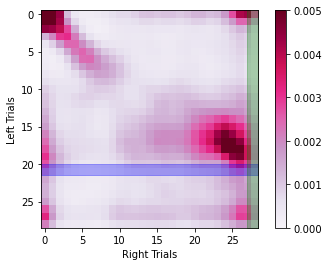

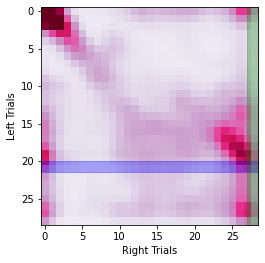

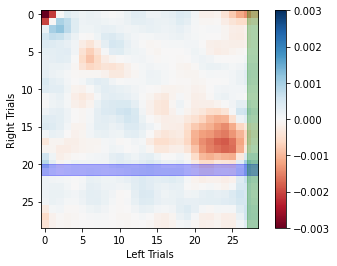

In [23]:
day = 5

ctrl_hist_sm = 0
for mouse in ctrl_mice:
    ctrl_hist_sm += get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
ctrl_hist_sm /= len(ctrl_mice)
ctrl_hist_sm /= ctrl_hist_sm.ravel().sum()

fig,ax = plt.subplots()
h = ax.imshow(ctrl_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
fig.savefig(os.path.join(figdir,"ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

ko_hist_sm = 0
for mouse in ko_mice:
    ko_hist_sm += get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
ko_hist_sm /= len(ko_mice)
ko_hist_sm /= ko_hist_sm.ravel().sum()

fig,ax = plt.subplots()
ax.imshow(ko_hist_sm,vmin=0,vmax=.005, cmap = 'PuRd')
ax.set_ylabel("Left Trials")
ax.set_xlabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
fig.savefig(os.path.join(figdir,"ko_lr_remap_hist_day%d.pdf" % day),format='pdf')

fig,ax = plt.subplots()
h = ax.imshow(-1*ctrl_hist_sm+ko_hist_sm,cmap='RdBu', vmin= -.003, vmax = .003)
ax.set_xlabel("Left Trials")
ax.set_ylabel("Right Trials")
ax.fill_between(np.linspace(-.5,28.5), rz_early[0], rz_early[1]-.5,  alpha=.3, color='blue')
ax.fill_betweenx(np.linspace(-.5,28.5), rz_late[0], rz_late[1]-.5,  alpha=.3, color='green')
plt.colorbar(h,ax = ax)
fig.savefig(os.path.join(figdir,"ko_v_ctrl_lr_remap_hist_day%d.pdf" % day),format='pdf')

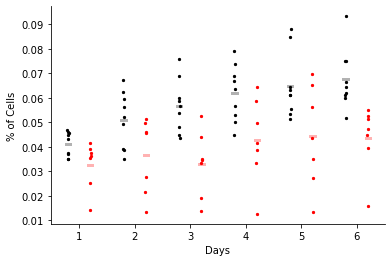

In [24]:
fig,ax = plt.subplots()

ctrl_reward_cells = np.zeros([6,len(ctrl_mice)])
ko_reward_cells = np.zeros([6,len(ko_mice)])

df = pd.DataFrame({'mouse':[],
                    'ko':[],
                    'day':[], 
                    'frac': [], 
                    })

for day in range(6):
    for m, mouse in enumerate(ctrl_mice):
        _hist = get_smooth_hist(np.argmax(ctrl_left_mats[mouse][day],axis=0), np.argmax(ctrl_right_mats[mouse][day],axis=0))
        frac = _hist[rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)
        ctrl_reward_cells[day,m] = frac
        df = df.append({'mouse': m,
                        'ko': 0,
                        'day': day,
                        'frac': frac}, ignore_index=True)
        
        
    for m, mouse in enumerate(ko_mice):
        _hist = get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0))
        ko_reward_cells[day,m] = _hist[rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)
        df = df.append({'mouse': m+len(ctrl_mice),
                        'ko': 1,
                        'day': day,
                        'frac': frac}, ignore_index=True)
    
for day in range(6):
    ax.scatter(5*day-1 + np.linspace(-0.05,0.05, num = len(ctrl_mice)), ctrl_reward_cells[day,:] , color = 'black', s=5)
    ax.plot(5*day  -1 + np.array([-0.2,0.2]), ctrl_reward_cells[day,:].mean()*np.ones([2,]), color='black', linewidth = 3, alpha = .3)
    
    ax.scatter(5*day+1 + np.linspace(-0.05,0.05, num = len(ko_mice)), ko_reward_cells[day,:] , color = 'red', s=5)
    ax.plot(5*day  +1 + np.array([-0.2,0.2]), ko_reward_cells[day,:].mean()*np.ones([2,]), color='red', linewidth = 3, alpha = .3)
    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Days')
ax.set_ylabel("% of Cells")
ax.set_xticks(5*np.arange(6))
ax.set_xticklabels(np.arange(1,7))

fig.savefig(os.path.join(figdir,"reward_cell_summary.pdf"))
# ko_hist_sm = []
# for mouse in ko_mice:
#     ko_hist_sm.append(get_smooth_hist(np.argmax(ko_left_mats[mouse][day],axis=0), np.argmax(ko_right_mats[mouse][day],axis=0)))

# ko_hist_sm = np.array(ko_hist_sm)
# ko_reward_cells = ko_hist_sm[:,rz_early[0][0]-5:rz_early[0][0]-1,rz_late[0][0]-5:rz_late[0][0]-1].sum(axis=-1).sum(axis=-1)

In [29]:
res = pg.mixed_anova(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse')
print(res)

posthoc = pg.pairwise_ttests(data = df, dv= 'frac', between = 'ko', within = 'day', subject = 'mouse', padjust='holm')
print(posthoc)

        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.003283    1   14  0.003283  19.015692  6.523878e-04   
1          day  0.014929    5   70  0.002986  61.985600  2.374681e-24   
2  Interaction  0.002203    5   70  0.000441   9.146256  9.896419e-07   

        np2       eps  
0  0.575959       NaN  
1  0.815755  0.348255  
2  0.395151       NaN  
    Contrast  day    A    B Paired  Parametric          T   dof alternative  \
0        day    -  0.0  1.0   True        True  -5.585486  15.0   two-sided   
1        day    -  0.0  2.0   True        True  -6.578183  15.0   two-sided   
2        day    -  0.0  3.0   True        True -11.682106  15.0   two-sided   
3        day    -  0.0  4.0   True        True -10.144773  15.0   two-sided   
4        day    -  0.0  5.0   True        True -10.272721  15.0   two-sided   
5        day    -  1.0  2.0   True        True  -2.110252  15.0   two-sided   
6        day    -  1.0  3.0   True        True  -6.742872 

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/pingouin/distribution.py:946: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


3.5501567623876005 0.0031999307671326544


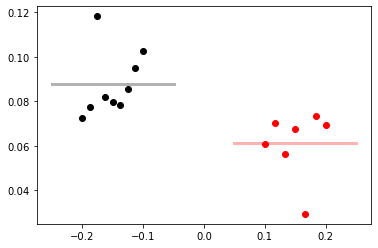

In [104]:
t,p = sp.stats.ttest_ind(ctrl_reward_cells, ko_reward_cells)
print(t,p)

fig,ax = plt.subplots()
ax.scatter(np.linspace(-.2,-.1,num=len(ctrl_mice)), ctrl_reward_cells, color= 'black')
ax.plot(np.array([-.25,-.05]), ctrl_reward_cells.mean()*np.ones([2,]),color='black', alpha=.3,linewidth=3)
ax.scatter(np.linspace(.1,.2,num=len(ko_mice)), ko_reward_cells, color= 'red')
ax.plot(np.array([.05,.25]), ko_reward_cells.mean()*np.ones([2,]),color='red', alpha=.3,linewidth=3)


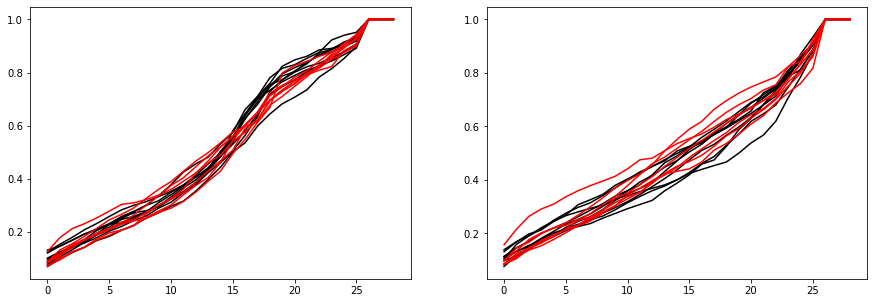

In [64]:
fig,ax = plt.subplots(1,2,figsize=[15,5])


day = 5
for mouse in ctrl_mice:
    lm, edges = np.histogram(np.argmax(ctrl_left_mats[mouse][day][1:,:],axis=0),bins=np.arange(0,30))
    ax[0].plot(np.cumsum(lm/lm.sum()), color='black')
    
    rm, edges = np.histogram(np.argmax(ctrl_right_mats[mouse][day][1:,:],axis=0),bins=np.arange(0,30))
    ax[1].plot(np.cumsum(rm/rm.sum()), color='black')
    
for mouse in ko_mice:
    lm, edges = np.histogram(np.argmax(ko_left_mats[mouse][day][1:,:],axis=0),bins=np.arange(0,30))
    ax[0].plot(np.cumsum(lm/lm.sum()), color='red')
    
    rm, edges = np.histogram(np.argmax(ko_right_mats[mouse][day][1:,:],axis=0),bins=np.arange(0,30))
    ax[1].plot(np.cumsum(rm/rm.sum()), color='red')

In [21]:
hist_sm = get_smooth_hist(np.argmax(left_mat,axis=0),np.argmax(right_mat,axis=0))


1.0


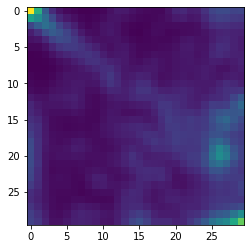

In [22]:
fig,ax= plt.subplots()
ax.imshow(hist_sm)
print(hist_sm.ravel().sum())

In [ ]:
fam_speed = stx.reward_overrep.PeriRewardSpeed(fam=True)

In [ ]:
fig, ax = fam_speed.perireward_plot()
fig.savefig(os.path.join(figdir, 'fam_perireward_speed.pdf'),format = 'pdf')

In [ ]:
nov_speed = stx.reward_overrep.PeriRewardSpeed(fam=False)

In [ ]:
fig, ax = nov_speed.perireward_plot()
fig.savefig(os.path.join(figdir, 'nov_perireward_speed.pdf'),format = 'pdf')

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


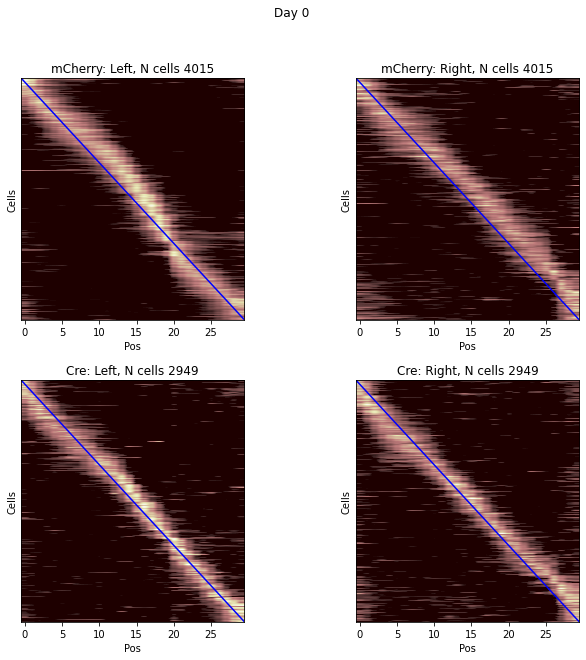

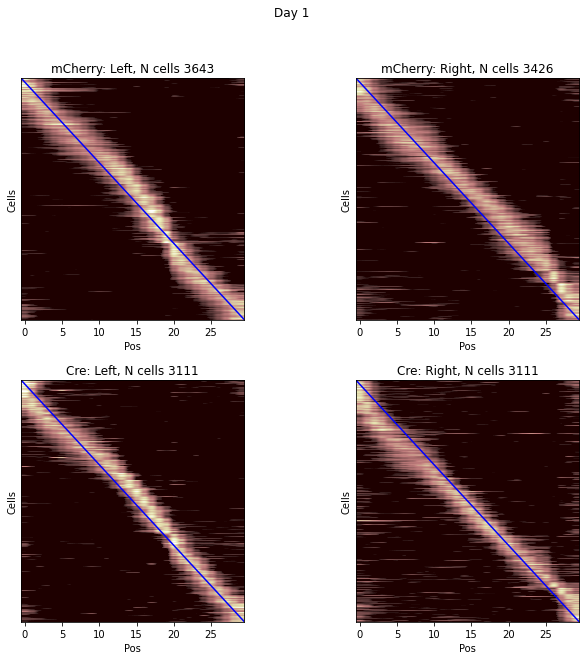

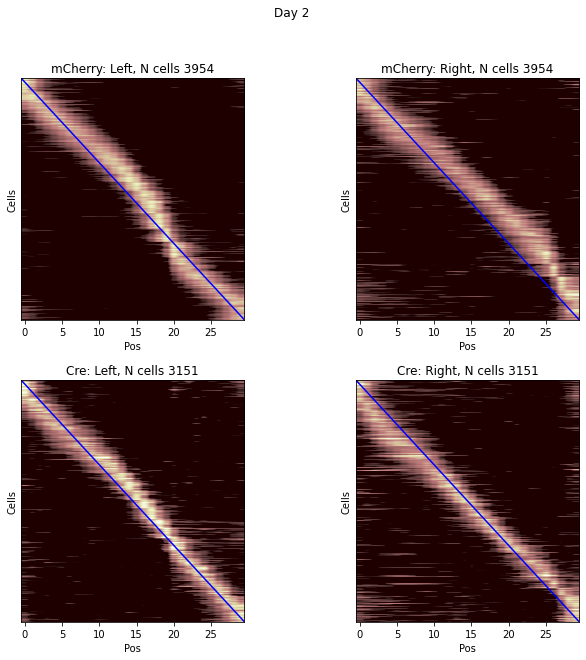

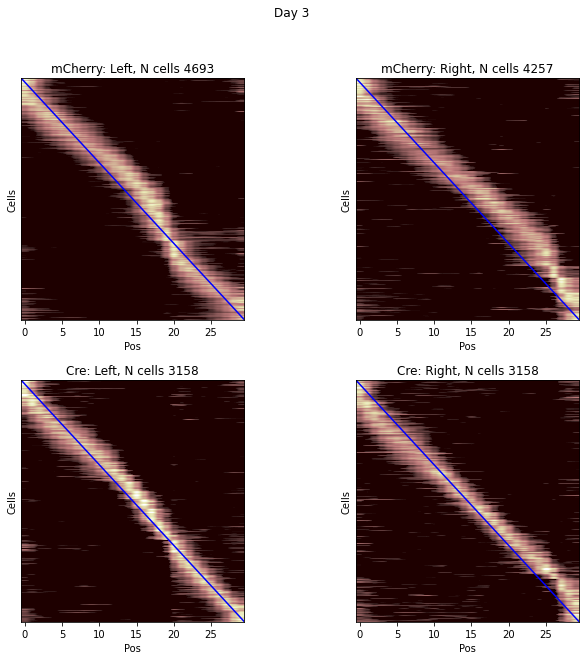

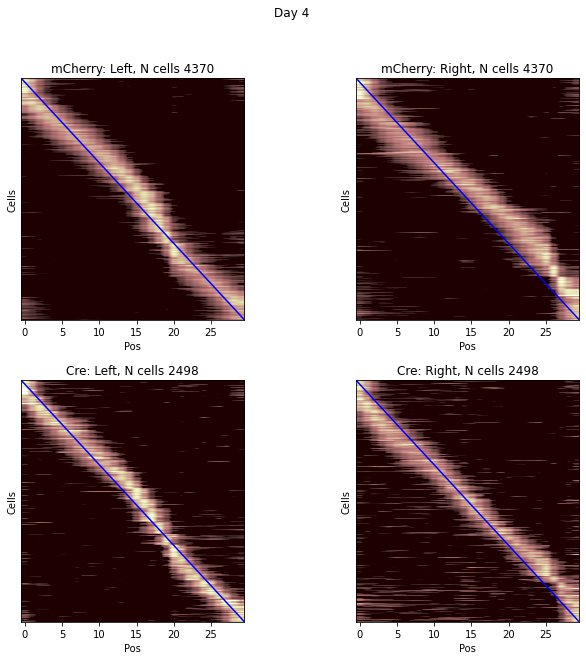

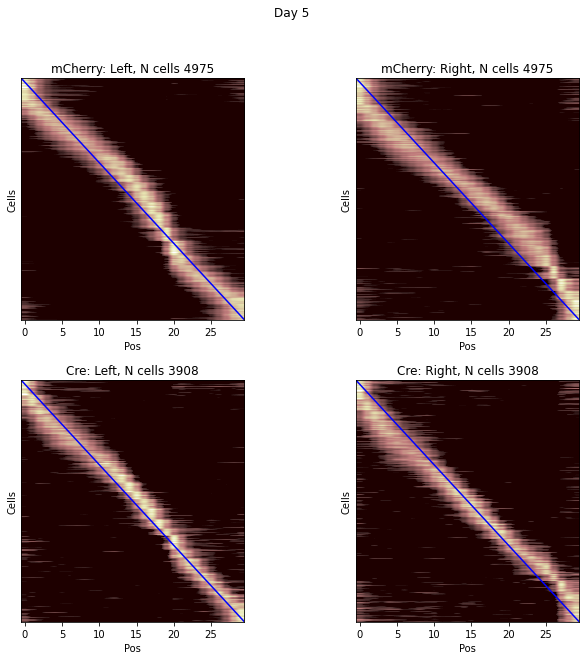

In [17]:
for day in range(6):
    fig,ax = stx.reward_overrep.plot_leftright_crossval_placecells_withinday(day, ts_key = 'spks', vmin = 0, vmax=4)
    fig.savefig(os.path.join(figdir,"population_placecells_day%d.pdf" % day), format='pdf')